# Testing QuCumber (from PIQuIL) with Optimized Hyperparameters for the Reconstruction of a positive-real wavefunction  
### 

Using one of the datasets in the tutorial, I reconstruct a **positive-real** wavefunction by training a QuCumber's *Restricted Boltzmann Machine* (RBM) neural network. However, here I will implement a trivial optimisation algorithm on its hyperparameters and compare it to the recommended list of hyperparamters in the tutorials found on the documentation page, and in turn to the default parameters. 

Preview of results : The plots and data, by the end of my investogation, showed that the recommended hyperparameters produced a fidelity of approximately `0.987`, while the default hyperparameters yield approximately `0.769`, and finally my optimized parameters yielded `0.995` but it still took longer to train, so the feasability of choosing to optimize might not be that great. In addition, the optimized parameters required considerably less number of training cycles (epochs) compared to the default and recommended hyperparameters.

NB: "The data used for training are $\sigma^{z}$ measurements from a one-dimensional transverse-field Ising model (TFIM) with 10 sites at its critical point." meaning $H=j=1$ for the hamiltonian:

$$H = -J\sum_i \sigma^z_i \sigma^z_{i+1} - h \sum_i\sigma^x_i$$

# Steps:
#### 1.0 Training:
1.1. Importing the QuCumber Library and setting up the training data set.  
1.2. Introducing the Hyperparameters.  
1.3. Defining our metric functions for quantizing the "distance" between generated and actual states.  
1.4. Constructing our cost functions for optimization based off of our metric function.  
1.5. Optimization of the training hyperparameters.  
  
#### 2.0 Evaluating the reconstruction results from the 3 cases, Default, Recommended and Optimized  
2.1. Preparing the training function for the three cases with appropriate parameters.  
2.2. Plotting and evaluating results and comparisons.  
2.3. Saving the weights determined by the training along with the hidden and visible biases as Torch tensors.
  

## 1.0. Training

### 1.1. Importing the QuCumber Library and setting up the training data set.

In [2]:
## importing necessary packages, including numpy, matplotlib, and QuCumber objects/classes
import numpy as np
import matplotlib.pyplot as plt

from qucumber.nn_states import PositiveWaveFunction ## importing the "wavefucntion" object


In [3]:
import torch

The metricevaluator is a function that we will use to monitor how close using some "metric"
we get to choose, the tutorial proposes the built in metric of fidelity, but I will use a
trace property here very similar to the trace distance to measure how close the recosntructed
states are to the real states as we progress, It will also be used for evaluating how well our
Hyperparameters are doing and for its cost function during classical optimization. I will also Add the Kullback-Leibler (KL) divergence (the RBM's cost function) for reference to the tutorial's example.

In [4]:
from qucumber.callbacks import MetricEvaluator 

## importing items for setting up datasets as we progress
import qucumber.utils.training_statistics as ts
import qucumber.utils.data as data
import qucumber

# setting random seed on cpu as indicated in the tutorial tutorial
qucumber.set_random_seed(1234, cpu=True, gpu=False)

In [5]:
'''first we import the data from the tutorial file, we need both the training set
and the true wave functions'''

psi_path = "tfim1d_psi.txt"
train_path = "tfim1d_data.txt"
train_data, true_psi = data.load_data(train_path, psi_path)


makng sure the traning data was loaded successfully:

In [6]:
train_data ## we can see that it is a pytorch Tensor object.

tensor([[1., 0., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 0., 1., 1.],
        [1., 1., 1.,  ..., 0., 0., 0.],
        ...,
        [1., 0., 0.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 0., 0.],
        [1., 1., 1.,  ..., 1., 0., 0.]], dtype=torch.float64)

### 1.2. Introducing the Hyperparameters.


#### Hyper-parameters:

#### Definitions as per documentation file and tutorial:

1. `epochs`: the total number of training cycles that will be performed (default = 100)
2. `pbs` (`pos_batch_size`): the number of data points used in the positive phase of the gradient (default = 100)
3. `nbs` (`neg_batch_size`): the number of data points used in the negative phase of the gradient (default = 100)
4. `k`: the number of contrastive divergence steps (default = 1)
5. `lr`: the learning rate (default = 0.001)

     
It is proposed in the documentation that:
"For the TFIM with 10 sites, the following hyperparameters give excellent results":  
#### 
$$epochs = 500$$
$$pbs = 100$$
$$nbs = pbs$$
$$lr = 0.01$$
$$k = 10$$


### 1.3. Defining our metric functions for quantizing the "distance" between generated and actual states.


In [7]:
'''Here we define our trace-based metric function'''

def Trace_dist(nn_state, space, **kwargs):
    norm = nn_state.compute_normalization(space).sqrt_()

    return torch.norm(((nn_state.psi(space)/norm)-true_psi))


### 1.4. Constructing our cost functions for optimization based off of our metric function.


To optimise our Hyperparameters we will refer to the distance metric at the 200th epochs and aim to optimise it using classical `COBYLA` from the SciPy package. I have it in Qiskit so I'll import it from there. To achieve this we need a cost function which targets that metric, we will call this function `get_Tr_dist`

In [8]:
def get_Tr_dist(params):
    
    ## the hidden and visible units are the same as was suggested and we turn Off the GPU
    
    nv = train_data.shape[-1]
    nh = nv
    nn_state = PositiveWaveFunction(num_visible=nv, num_hidden=nh, gpu=False)
    '''we then create a hilbert space corresponding to our state space'''
    space = nn_state.generate_hilbert_space()
    period = 10  ## the frequency with which the metric evaluation will be applied during training
    
    ###################################################################################################
    ############# callbacks is a list holding all the metric evaluations ##################
    callbacks = [
    MetricEvaluator(
        period,
        {"Tr_dist": Trace_dist},
        target=true_psi,
        verbose=True,
        space=space,
    )
    ]
    ###################################################################################################
    ######### QuCumber's fit function runs the training given the Hyperparameters and Data ############
    nn_state.fit(
    train_data,
    epochs = 200,
    pos_batch_size = int(params[0]),
    neg_batch_size = int(params[0]),
    lr = 0.01,
    k = int(params[1]),
    callbacks=callbacks,
    time=True, ## keeps track of time taken to train
    )
    
    ###################################################################################################
    ################ Here I define the trace-based metric for evaluating state distance measure #######
    norm = nn_state.compute_normalization(space).sqrt_()
    torch.norm(((nn_state.psi(space)/norm)-true_psi))
    return (torch.norm(((nn_state.psi(space)/norm)-true_psi))).item()

### 1.5. Optimization of the training hyperparameters.


In [9]:
from qiskit.aqua.components.optimizers import COBYLA

# Initializing the COBYLA optimizer with 500 maximum iterations and small tolerance of 0.0001
optimizer = COBYLA(disp = True, maxiter=100, tol=0.01, rhobeg = 20)

##*** Creating the initial parameters, taking care they are 8, so we initialize with angles zero on every gate
# and the optimizer picks up from there ***##

p= [4,1]## an array of eight angles all zeros as our starting point for optimization

Get_Optimum_Params = optimizer.optimize(num_vars=2, objective_function = get_Tr_dist , initial_point=p)

Epoch: 10	Tr_dist = 0.221155
Epoch: 20	Tr_dist = 0.146574
Epoch: 30	Tr_dist = 0.115323
Epoch: 40	Tr_dist = 0.131557
Epoch: 50	Tr_dist = 0.080644
Epoch: 60	Tr_dist = 0.115759
Epoch: 70	Tr_dist = 0.133217
Epoch: 80	Tr_dist = 0.122614
Epoch: 90	Tr_dist = 0.094514
Epoch: 100	Tr_dist = 0.174205
Epoch: 110	Tr_dist = 0.108162
Epoch: 120	Tr_dist = 0.122816
Epoch: 130	Tr_dist = 0.130737
Epoch: 140	Tr_dist = 0.138754
Epoch: 150	Tr_dist = 0.143156
Epoch: 160	Tr_dist = 0.112590
Epoch: 170	Tr_dist = 0.089324
Epoch: 180	Tr_dist = 0.227231
Epoch: 190	Tr_dist = 0.113496
Epoch: 200	Tr_dist = 0.107292
Total time elapsed during training: 182.629 s
Epoch: 10	Tr_dist = 0.498702
Epoch: 20	Tr_dist = 0.339266
Epoch: 30	Tr_dist = 0.276638
Epoch: 40	Tr_dist = 0.234277
Epoch: 50	Tr_dist = 0.206605
Epoch: 60	Tr_dist = 0.187698
Epoch: 70	Tr_dist = 0.163130
Epoch: 80	Tr_dist = 0.152811
Epoch: 90	Tr_dist = 0.157116
Epoch: 100	Tr_dist = 0.124638
Epoch: 110	Tr_dist = 0.132043
Epoch: 120	Tr_dist = 0.118313
Epoch: 130	T

Epoch: 200	Tr_dist = 0.078587
Total time elapsed during training: 179.147 s
Epoch: 10	Tr_dist = 0.336772
Epoch: 20	Tr_dist = 0.244517
Epoch: 30	Tr_dist = 0.183271
Epoch: 40	Tr_dist = 0.147124
Epoch: 50	Tr_dist = 0.130545
Epoch: 60	Tr_dist = 0.111600
Epoch: 70	Tr_dist = 0.102076
Epoch: 80	Tr_dist = 0.104849
Epoch: 90	Tr_dist = 0.100615
Epoch: 100	Tr_dist = 0.088374
Epoch: 110	Tr_dist = 0.128131
Epoch: 120	Tr_dist = 0.074908
Epoch: 130	Tr_dist = 0.081473
Epoch: 140	Tr_dist = 0.074119
Epoch: 150	Tr_dist = 0.069860
Epoch: 160	Tr_dist = 0.081453
Epoch: 170	Tr_dist = 0.093351
Epoch: 180	Tr_dist = 0.085420
Epoch: 190	Tr_dist = 0.067556
Epoch: 200	Tr_dist = 0.103366
Total time elapsed during training: 178.991 s
Epoch: 10	Tr_dist = 0.343952
Epoch: 20	Tr_dist = 0.250704
Epoch: 30	Tr_dist = 0.197794
Epoch: 40	Tr_dist = 0.174936
Epoch: 50	Tr_dist = 0.155431
Epoch: 60	Tr_dist = 0.136136
Epoch: 70	Tr_dist = 0.118597
Epoch: 80	Tr_dist = 0.114347
Epoch: 90	Tr_dist = 0.109985
Epoch: 100	Tr_dist = 0.101

Epoch: 170	Tr_dist = 0.087892
Epoch: 180	Tr_dist = 0.084426
Epoch: 190	Tr_dist = 0.076502
Epoch: 200	Tr_dist = 0.076491
Total time elapsed during training: 170.549 s
Epoch: 10	Tr_dist = 0.357236
Epoch: 20	Tr_dist = 0.253470
Epoch: 30	Tr_dist = 0.198993
Epoch: 40	Tr_dist = 0.180218
Epoch: 50	Tr_dist = 0.151801
Epoch: 60	Tr_dist = 0.126485
Epoch: 70	Tr_dist = 0.114513
Epoch: 80	Tr_dist = 0.115749
Epoch: 90	Tr_dist = 0.101946
Epoch: 100	Tr_dist = 0.104505
Epoch: 110	Tr_dist = 0.097896
Epoch: 120	Tr_dist = 0.086856
Epoch: 130	Tr_dist = 0.088798
Epoch: 140	Tr_dist = 0.101532
Epoch: 150	Tr_dist = 0.079940
Epoch: 160	Tr_dist = 0.079899
Epoch: 170	Tr_dist = 0.074269
Epoch: 180	Tr_dist = 0.074290
Epoch: 190	Tr_dist = 0.100884
Epoch: 200	Tr_dist = 0.087619
Total time elapsed during training: 169.492 s


In [11]:
print("This corresponds to the parameter set: " , Get_Optimum_Params[0])
print("the number of iterations taken to get the value was: " , Get_Optimum_Params[2])

This corresponds to the parameter set:  [16.79524326 21.91082729]
the number of iterations taken to get the value was:  27


Given the parameter outputs, I will use `17` and `21`, the closest integers

## 2.0 Evaluating the reconstruction results from the 3 cases, Default, Recommended and Optimized

Now to compare my Optimized Hyperparameters' results to those of the default Hyperparameters and recommended Hyperparameters

### 2.1. Preparing the training function for the three cases with appropriate parameters.  


In [12]:
def get_Tr_dist_results(params):
    
    ## the hidden and visible units are the same as was suggested and we turn On the GPU
    
    nv = train_data.shape[-1]
    nh = nv
    nn_state = PositiveWaveFunction(num_visible=nv, num_hidden=nh, gpu=False)
    '''we then create a hilbert space corresponding to our state space'''
    space = nn_state.generate_hilbert_space()
    period = 10 
    
    callbacks = [
    MetricEvaluator(
        period,
        {"Fidelity": ts.fidelity, "KL": ts.KL,"Tr_dist": Trace_dist},
        target=true_psi,
        verbose=True,
        space=space,
    )
    ]
    
    nn_state.fit(
    train_data,
    epochs = params[0],
    pos_batch_size = int(params[1]),
    neg_batch_size = int(params[1]),
    lr = params[2],
    k = int(params[3]),
    callbacks=callbacks,
    time=True,
    )
    
    norm = nn_state.compute_normalization(space).sqrt_()
    torch.norm(((nn_state.psi(space)/norm)-true_psi))
    return nn_state, callbacks

In [14]:
""" The results for default Hyperparameters """
temp_params_list_default = [500,100,0.001,1] ## these are the default parameters
default_results = get_Tr_dist_results(temp_params_list_default)

Epoch: 10	Fidelity = 0.444266	KL = 1.751417	Tr_dist = 0.816660
Epoch: 20	Fidelity = 0.459738	KL = 1.665469	Tr_dist = 0.802446
Epoch: 30	Fidelity = 0.465698	KL = 1.630824	Tr_dist = 0.796968
Epoch: 40	Fidelity = 0.470383	KL = 1.603464	Tr_dist = 0.792661
Epoch: 50	Fidelity = 0.475173	KL = 1.576187	Tr_dist = 0.788254
Epoch: 60	Fidelity = 0.480125	KL = 1.548210	Tr_dist = 0.783696
Epoch: 70	Fidelity = 0.485261	KL = 1.519961	Tr_dist = 0.778965
Epoch: 80	Fidelity = 0.490453	KL = 1.491667	Tr_dist = 0.774179
Epoch: 90	Fidelity = 0.495721	KL = 1.463569	Tr_dist = 0.769319
Epoch: 100	Fidelity = 0.501041	KL = 1.435927	Tr_dist = 0.764405
Epoch: 110	Fidelity = 0.506311	KL = 1.408184	Tr_dist = 0.759533
Epoch: 120	Fidelity = 0.511673	KL = 1.381428	Tr_dist = 0.754568
Epoch: 130	Fidelity = 0.517092	KL = 1.354994	Tr_dist = 0.749545
Epoch: 140	Fidelity = 0.522509	KL = 1.328049	Tr_dist = 0.744516
Epoch: 150	Fidelity = 0.528103	KL = 1.301395	Tr_dist = 0.739315
Epoch: 160	Fidelity = 0.533738	KL = 1.274491	Tr_d

#### To access the individual results we can call on the `callbacks` list which is part of the return of the function:

In [15]:
'''it is the seond element in the return of the function and the 1st element in that object, then we specify 
which metric we want to extract, here I extracted fidelity: 
NB: to get the `nn_state` we just access the first element of the result '''

default_results[1][0].Fidelity

array([0.44426633, 0.45973824, 0.46569807, 0.47038283, 0.47517291,
       0.48012511, 0.48526101, 0.4904533 , 0.49572057, 0.50104108,
       0.50631052, 0.51167325, 0.51709165, 0.52250865, 0.52810272,
       0.53373775, 0.53953528, 0.54551551, 0.55164127, 0.55796157,
       0.56447094, 0.57112339, 0.57794981, 0.58510268, 0.59241223,
       0.59974735, 0.60719024, 0.61484775, 0.62276592, 0.63011613,
       0.63818591, 0.64580789, 0.65373431, 0.66190836, 0.66908673,
       0.67648609, 0.68376312, 0.69157492, 0.69865674, 0.70561406,
       0.71227666, 0.7185035 , 0.72655756, 0.7328041 , 0.73993462,
       0.74673921, 0.75149961, 0.75679289, 0.76236957, 0.76923995])

Preparing the function for the recommended parameters:

In [16]:
""" The results for recommended Hyperparameters """
temp_params_list_recommended = [500,100,0.01,10] ## These are the recommended parameters
recommended_results = get_Tr_dist_results(temp_params_list_recommended)

Epoch: 10	Fidelity = 0.546028	KL = 1.198868	Tr_dist = 0.722583
Epoch: 20	Fidelity = 0.663991	KL = 0.768168	Tr_dist = 0.608512
Epoch: 30	Fidelity = 0.754252	KL = 0.534584	Tr_dist = 0.512880
Epoch: 40	Fidelity = 0.801331	KL = 0.431223	Tr_dist = 0.457885
Epoch: 50	Fidelity = 0.832730	KL = 0.351806	Tr_dist = 0.418233
Epoch: 60	Fidelity = 0.860309	KL = 0.285439	Tr_dist = 0.380714
Epoch: 70	Fidelity = 0.882499	KL = 0.238636	Tr_dist = 0.348097
Epoch: 80	Fidelity = 0.897492	KL = 0.209462	Tr_dist = 0.324468
Epoch: 90	Fidelity = 0.907271	KL = 0.189595	Tr_dist = 0.308196
Epoch: 100	Fidelity = 0.915087	KL = 0.173892	Tr_dist = 0.294612
Epoch: 110	Fidelity = 0.920909	KL = 0.161063	Tr_dist = 0.284113
Epoch: 120	Fidelity = 0.928057	KL = 0.146544	Tr_dist = 0.270714
Epoch: 130	Fidelity = 0.934020	KL = 0.133426	Tr_dist = 0.259048
Epoch: 140	Fidelity = 0.939528	KL = 0.121663	Tr_dist = 0.247820
Epoch: 150	Fidelity = 0.945286	KL = 0.109587	Tr_dist = 0.235550
Epoch: 160	Fidelity = 0.949561	KL = 0.100631	Tr_d

Preparing the function for the Optimized parameters:

In [18]:
""" The results for optimized Hyperparameters """
temp_params_list_optimized = [500,17,0.01,22] ## These are my parameters/ the optimised ones
optimized_results = get_Tr_dist_results(temp_params_list_optimized)

Epoch: 10	Fidelity = 0.865395	KL = 0.275696	Tr_dist = 0.373454
Epoch: 20	Fidelity = 0.932406	KL = 0.138934	Tr_dist = 0.262252
Epoch: 30	Fidelity = 0.958826	KL = 0.082368	Tr_dist = 0.203978
Epoch: 40	Fidelity = 0.967376	KL = 0.066723	Tr_dist = 0.181368
Epoch: 50	Fidelity = 0.974473	KL = 0.051843	Tr_dist = 0.160289
Epoch: 60	Fidelity = 0.979614	KL = 0.040854	Tr_dist = 0.143145
Epoch: 70	Fidelity = 0.983529	KL = 0.033149	Tr_dist = 0.128604
Epoch: 80	Fidelity = 0.984581	KL = 0.031163	Tr_dist = 0.124415
Epoch: 90	Fidelity = 0.987710	KL = 0.024816	Tr_dist = 0.111033
Epoch: 100	Fidelity = 0.989781	KL = 0.020702	Tr_dist = 0.101220
Epoch: 110	Fidelity = 0.985865	KL = 0.028786	Tr_dist = 0.119103
Epoch: 120	Fidelity = 0.991697	KL = 0.016819	Tr_dist = 0.091215
Epoch: 130	Fidelity = 0.991371	KL = 0.017466	Tr_dist = 0.092993
Epoch: 140	Fidelity = 0.985492	KL = 0.029458	Tr_dist = 0.120668
Epoch: 150	Fidelity = 0.987796	KL = 0.024675	Tr_dist = 0.110641
Epoch: 160	Fidelity = 0.993501	KL = 0.012974	Tr_d

All of these training evaluators can be accessed after the training has completed. The code below shows this, along with plots of each training evaluator as a function of epoch (training cycle number).

In [20]:
'''We now extract the results from the various training processes for plotting we already know we can
access the metrics by calling on `callbacks` list which is the return of the function we use to 
recreate the wavefunction'''

fidelities_default = default_results[1][0]["Fidelity"]
KLs_default = default_results[1][0]["KL"]
Tr_dist_default = default_results[1][0]["Tr_dist"]
period = 10
epoch = np.arange(period, 500 + 1, period)
########################################################################################
fidelities_recommended = recommended_results[1][0].Fidelity
KLs_recommended = recommended_results[1][0]["KL"]
Tr_dist_recommended = recommended_results[1][0]["Tr_dist"]
########################################################################################
fidelities_optimized = optimized_results[1][0].Fidelity
KLs_optimized = optimized_results[1][0]["KL"]
Tr_dist_optimized = optimized_results[1][0]["Tr_dist"]



### 2.2. Plotting and evaluating results and comparisons.

In [21]:
# Some parameters as given by the tutorial for plotting
params = {
    "text.usetex": True,
    "font.family": "serif",
    "legend.fontsize": 14,
    "figure.figsize": (10, 3),
    "axes.labelsize": 16,
    "xtick.labelsize": 14,
    "ytick.labelsize": 14,
    "lines.linewidth": 2,
    "lines.markeredgewidth": 0.8,
    "lines.markersize": 5,
    "lines.marker": "o",
    "patch.edgecolor": "black",
}
plt.rcParams.update(params)
plt.style.use("seaborn-deep")

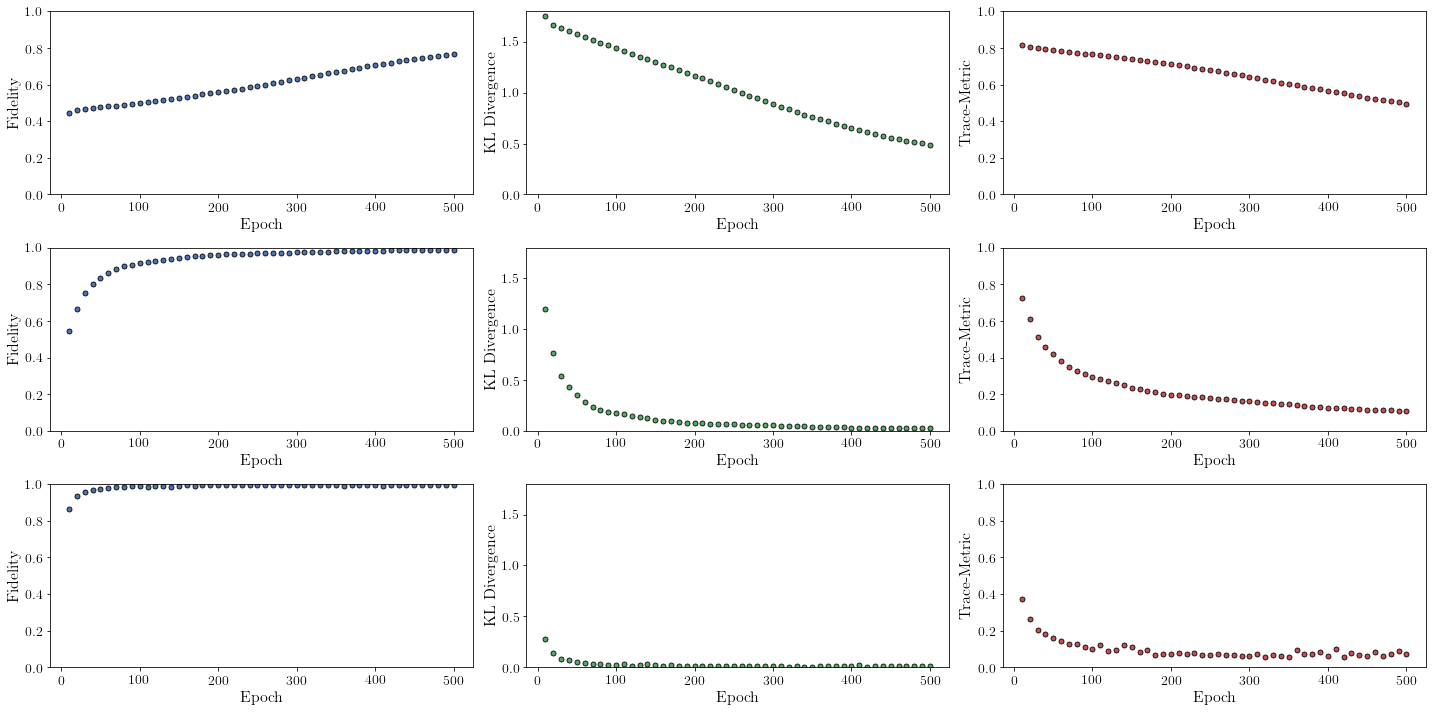

In [23]:
# Setting up the Plotting

fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(20, 10)) ## creating all plots in one table

#################### Here we access the plotting table in order ##############################
ax = axs[0][0]
ax.plot(epoch, fidelities_default, "o", color="C0", markeredgecolor="black")
ax.set_ylim([0, 1])
ax.set_ylabel(r"Fidelity")
ax.set_xlabel(r"Epoch")

ax = axs[0][1]
ax.plot(epoch, KLs_default, "o", color="C1", markeredgecolor="black")
ax.set_ylim([0, 1.8])
ax.set_ylabel(r"KL Divergence")
ax.set_xlabel(r"Epoch")

ax = axs[0][2]
ax.plot(epoch, Tr_dist_default, "o", color="C2", markeredgecolor="black")
ax.set_ylim([0, 1])
ax.set_ylabel(r"Trace-Metric")
ax.set_xlabel(r"Epoch")
###################################################################################
ax = axs[1][0]
ax.plot(epoch, fidelities_recommended, "o", color="C0", markeredgecolor="black")
ax.set_ylim([0, 1])
ax.set_ylabel(r"Fidelity")
ax.set_xlabel(r"Epoch")

ax = axs[1][1]
ax.plot(epoch, KLs_recommended, "o", color="C1", markeredgecolor="black")
ax.set_ylim([0, 1.8])
ax.set_ylabel(r"KL Divergence")
ax.set_xlabel(r"Epoch")

ax = axs[1][2]
ax.plot(epoch, Tr_dist_recommended, "o", color="C2", markeredgecolor="black")
ax.set_ylim([0, 1])
ax.set_ylabel(r"Trace-Metric")
ax.set_xlabel(r"Epoch")
###################################################################################
ax = axs[2][0]
ax.plot(epoch, fidelities_optimized, "o", color="C0", markeredgecolor="black")
ax.set_ylim([0, 1])
ax.set_ylabel(r"Fidelity")
ax.set_xlabel(r"Epoch")

ax = axs[2][1]
ax.plot(epoch, KLs_optimized, "o", color="C1", markeredgecolor="black")
ax.set_ylim([0, 1.8])
ax.set_ylabel(r"KL Divergence")
ax.set_xlabel(r"Epoch")

ax = axs[2][2]
ax.plot(epoch, Tr_dist_optimized, "o", color="C2", markeredgecolor="black")
ax.set_ylim([0, 1])
ax.set_ylabel(r"Trace-Metric")
ax.set_xlabel(r"Epoch")
###################################################################################

plt.tight_layout()
plt.show()

The plots and data show that the recommended hyperparameters produced a fidelity of approximately `0.987`, while the default hyperparameters yield approximately `0.769`, and finally my optimized parameters yielded
`0.995` but it still took longer to train, so the feasability of choosing to optimize might not be that great, I could further include running times in my optimization but that is something I leave for later. In addition, the optimized parameters required considerably less number of training cycles (epochs) compared to the default and recommended hyperparameters.

### 2.3. Saving the weights determined by the training along with the hidden and visible biases as Torch tensors.

In [24]:
"""The trained RBM can be saved to a pickle file with the 
name `saved_optimized_params.pt` for future use as per the tutorial instructions 

NB: We can access it from the return of the result functions for example "optimized_results[0], it will
be the first element in the returned list while the callback list was the second element"""

optimized_results[0].save("saved_optimized_params.pt")

As per the tutorial : ''This saves the weights, visible biases and hidden biases as torch tensors under the following keys: `weights`, `visible_bias`, `hidden_bias`.''

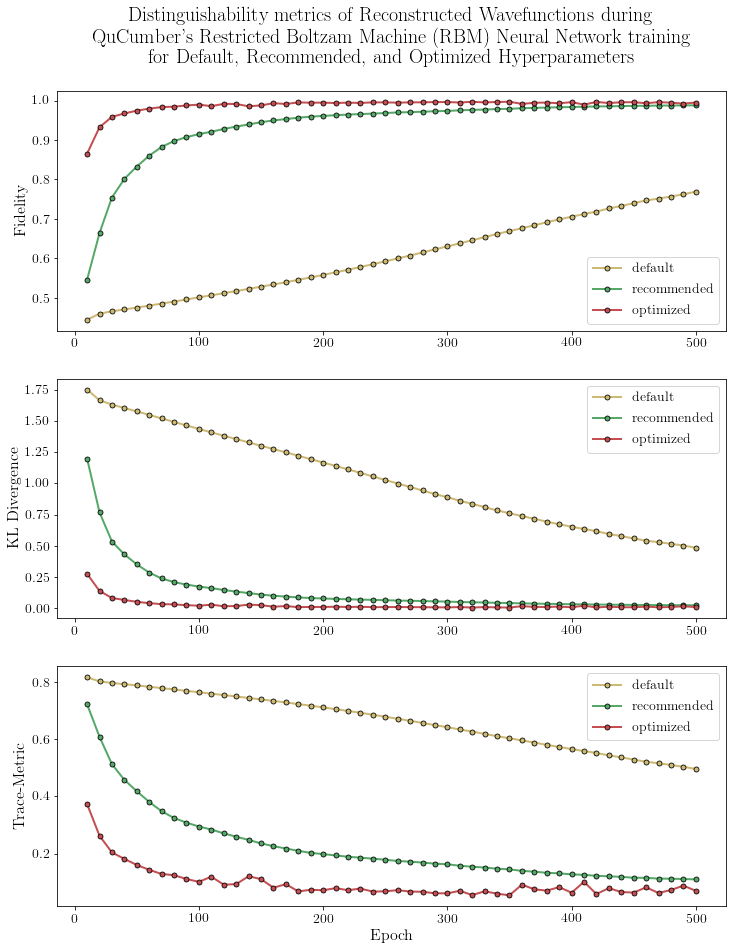

In [85]:
fig, (ax_1,ax_2,ax_3) = plt.subplots(nrows=3, ncols=1, figsize=(12, 15)) 
#setting up another table but this time to combine like-metrics for all the Hyperparameters to compare

#################################### First Plot for Fidelity #################################

ax_1.plot(epoch, fidelities_default, "o-", color="C4", markeredgecolor="black", label = 'default')
ax_1.plot(epoch, fidelities_recommended, "o-", color="C1", markeredgecolor="black",label = 'recommended')
ax_1.plot(epoch, fidelities_optimized, "o-", color="C2", markeredgecolor="black",label = 'optimized')

ax_1.set_ylabel(r"Fidelity")

ax_1.legend()
ax_1.set_title(('Distinguishability metrics of Reconstructed Wavefunctions during \n'+
                'QuCumber\'s Restricted Boltzam Machine (RBM) Neural Network training' + 
                ' \n for Default, Recommended, and Optimized Hyperparameters \n'), fontsize =20) 

#################################### Second Plot for KL Divergence #################################
ax_2.plot(epoch, KLs_default, "o-", color="C4", markeredgecolor="black", label = 'default')
ax_2.plot(epoch, KLs_recommended, "o-", color="C1", markeredgecolor="black",label = 'recommended')
ax_2.plot(epoch, KLs_optimized, "o-", color="C2", markeredgecolor="black",label = 'optimized')

ax_2.set_ylabel(r"KL Divergence")

ax_2.legend()

##################################### Third plot for Trace-metric ##################################

ax_3.plot(epoch, Tr_dist_default, "o-", color="C4", markeredgecolor="black", label = 'default')
ax_3.plot(epoch, Tr_dist_recommended, "o-", color="C1", markeredgecolor="black",label = 'recommended')
ax_3.plot(epoch, Tr_dist_optimized, "o-", color="C2", markeredgecolor="black",label = 'optimized')

ax_3.set_ylabel(r"Trace-Metric")

ax_3.legend()
 
ax_3.set_xlabel(r"Epoch")
plt.show()
##################################################################################################

In [1]:
'''adding some aesthetic options to the page'''

## these 2 lines justify markdwon cells
from IPython.core.display import display, HTML
display(HTML("<style>.text_cell_render p {text-align: justify; text-justify: inter-word;  }</style>"))

## this line enlarges the width of all cells
display(HTML("<style>.container { width:60% !important; }</style>"))